In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Activation, Masking, Concatenate, Input, Lambda, Average
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from itertools import product, combinations


In [2]:
file_name_dataset = "RAVDESS"
dataset_ravdess_dir = "../Dataset/RAVDESS/"
ravdess_dir_list = os.listdir(dataset_ravdess_dir)

In [3]:
emotion_dict = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [4]:
emotion_list = []
path_list = []

for dir in ravdess_dir_list:
    for audio_file in os.listdir(dataset_ravdess_dir + dir):
        emotion_segment = audio_file.split("-")[2]

        if emotion_segment in emotion_dict:
            emotion_list.append(emotion_dict[emotion_segment])
        else:
            emotion_list.append("unknown")

        audio_file_path = os.path.join(dataset_ravdess_dir, dir, audio_file)
        path_list.append(audio_file_path)

ravdess_df = pd.DataFrame({'Emotion': emotion_list, 'Path': path_list})
ravdess_df.to_csv("ravdess_df.csv", index = False)
ravdess_df.head()

,Emotion,Path
0,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-01-01-...
1,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-01-02-...
2,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-02-01-...
3,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-02-02-...
4,calm,../Dataset/RAVDESS/Actor_01\03-01-02-01-01-01-...


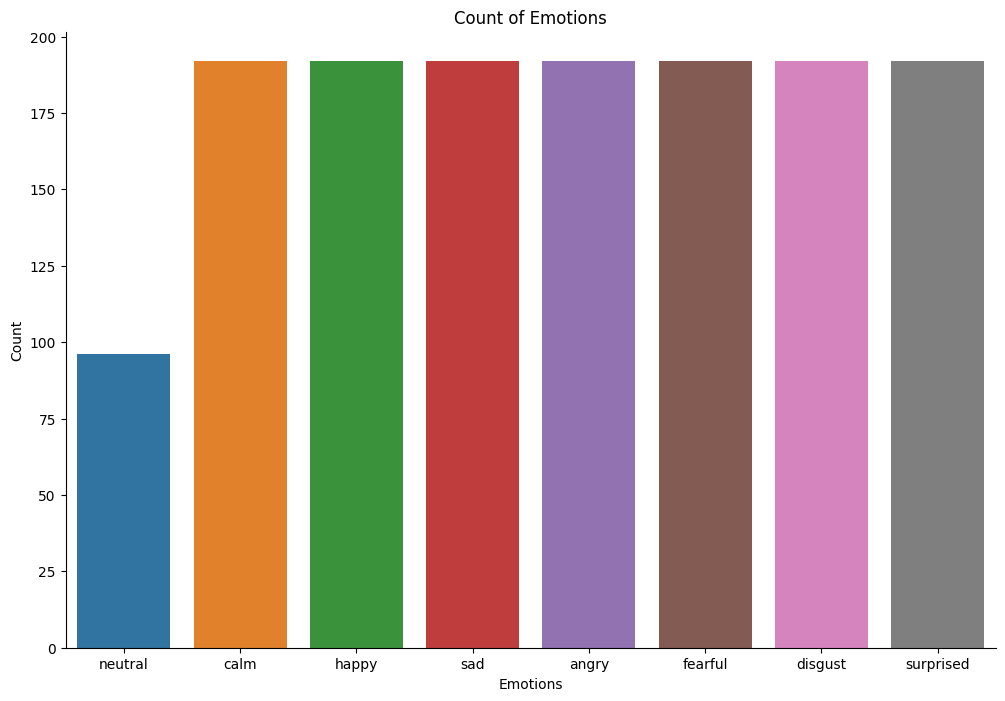

In [5]:
plt.figure(figsize=(12, 8))
plt.title('Count of Emotions')
sns.countplot(x = ravdess_df.Emotion)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [6]:
def waveplot(data, sr, emo):
  plt.figure(figsize = (6, 1))
  plt.title(f"{emo} audio waveplot")
  librosa.display.waveshow(data, sr = sr)

def spectrogram(data, sr, emo):
  X = librosa.stft(data)
  Xdb = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize = (6, 1))
  plt.title(f"{emo} audio spectrogram")
  librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'hz')

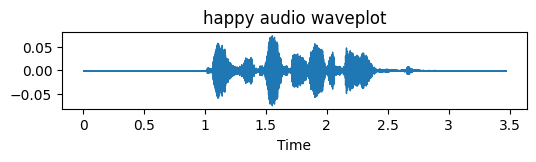

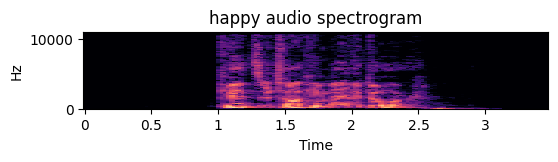

In [7]:
emotion = 'happy'

audio_file_path = np.array(ravdess_df.Path[ravdess_df.Emotion.str.contains(emotion)])[1]
data, sampling_rate = librosa.load(audio_file_path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(audio_file_path)

In [8]:
def noise(data):
  noise_amp = 0.04 * np.random.uniform() * np.amax(data)
  data = data + noise_amp * np.random.normal(size = data.shape[0])
  return data

def time_stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate = rate)

def shift(data, steps_range = (-5, 5)):
  shift_range = int(np.random.uniform(steps_range[0], steps_range[1]) * 1000)
  return np.roll(data, shift_range)

def pitch_shift(data, sampling_rate, n_steps = 0.7):
  return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = n_steps)

def random_time_stretch(data, stretch_factor_range = (0.8, 1.25)):
  random_stretch_factor = np.random.uniform(stretch_factor_range[0], stretch_factor_range[1])

  augmented_data = time_stretch(data, random_stretch_factor)

  if len(augmented_data) > len(data):
    augmented_data = augmented_data[:len(data)]
  else:
    padded_augmented_data = np.zeros_like(data)
    padded_augmented_data[:len(augmented_data)] = augmented_data
    augmented_data = padded_augmented_data

  return augmented_data

def random_pitch_shift(data, sampling_rate, steps_range=(-4, 4)):
  n_steps = np.random.randint(steps_range[0], steps_range[1] + 1)  
  return pitch_shift(data, sampling_rate, n_steps)

In [9]:
def extract_mel(data, sr, n_mels=128, fmax=8000):
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)
    return mel_spec;

def extract_log_mel_spec(data, sr, n_mels=128, fmax=8000):
    log_mel_spec = librosa.power_to_db(extract_mel(data, sr, n_mels, fmax))
    return log_mel_spec;

def extract_mfcc(data, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y = data, sr = sr, n_mfcc=n_mfcc)
    return mfcc;

def extract_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    return delta_mfcc;

def extract_delta_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    return delta2_mfcc;

def extract_zcr(data):
    zcr = librosa.feature.zero_crossing_rate(y=data)
    return zcr

def extract_rms(data):
    rms = librosa.feature.rms(y=data)
    return rms

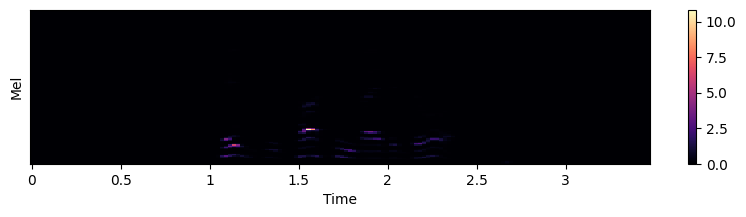

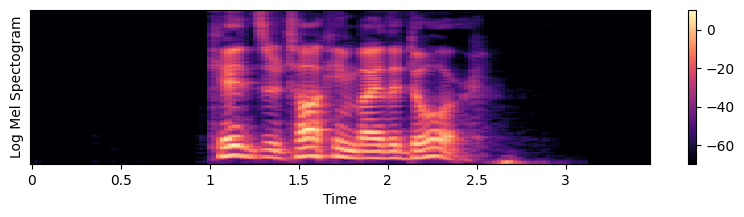

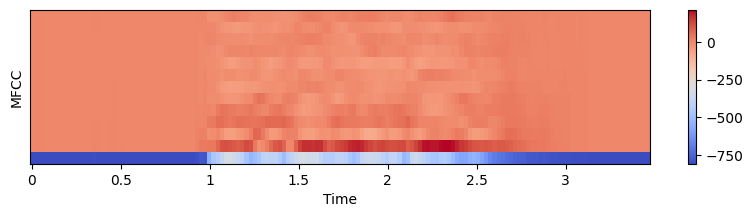

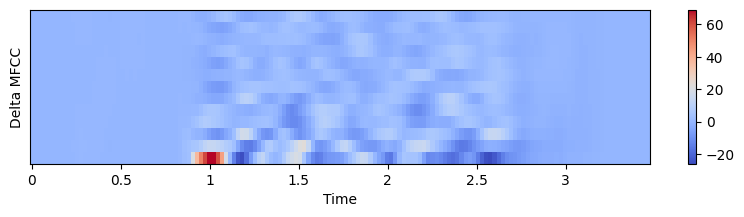

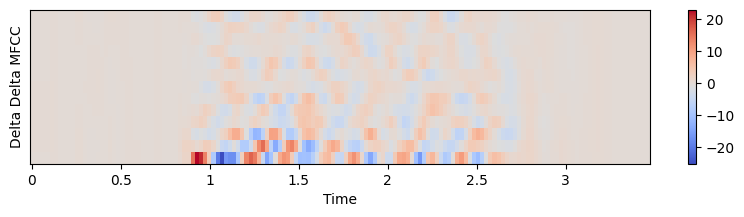

In [10]:
mel = extract_mel(data, sampling_rate, 128, 8000)
plt.figure(figsize=(10, 2))
librosa.display.specshow(mel, x_axis='time', sr = sampling_rate)
plt.ylabel('Mel')
plt.colorbar()

log_mel_spec = extract_log_mel_spec(data, sampling_rate, 128, 8000)
plt.figure(figsize=(10, 2))
librosa.display.specshow(log_mel_spec, x_axis='time', sr = sampling_rate)
plt.ylabel('Log Mel Spectogram')
plt.colorbar()

# MFCC
mfcc = extract_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('MFCC')
plt.colorbar()

# ΔMFCC
delta_mfcc = extract_delta_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(delta_mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('Delta MFCC')
plt.colorbar()

# ΔΔMFCC
delta_delta_mfcc = extract_delta_delta_mfcc(data, sampling_rate, 13)
plt.figure(figsize=(10, 2))
librosa.display.specshow(delta_delta_mfcc, x_axis='time', sr = sampling_rate)
plt.ylabel('Delta Delta MFCC')
plt.colorbar()
plt.show()

# MFCC-based approximate entropy
# MFCC-based spectral entropy
# Three-dimensional Mel-scale frequency cepstral coefficients

In [11]:
# feature_extraction_techniques = ["MFCC", "Delta MFCC", "Delta Delta MFCC"]
# feature_extraction_techniques = ["MFCC Mean 40", "Delta MFCC Mean 40", "Delta Delta MFCC Mean 40"]
feature_extraction_techniques = ["MFCC Mean 40"]

file_name_feat_extract = " & ".join(feature_extraction_techniques)

def extract_features(data, sr, n_mfcc=40):
    # MEAN
    features = np.array([])
    mfcc = extract_mfcc(data, sr, n_mfcc).T
    delta_delta_mfcc = extract_delta_delta_mfcc(data, sr, n_mfcc).T
    mfcc_mean = np.mean(mfcc, axis=0)
    # mfcc_min = np.min(mfcc, axis=0)
    # mfcc_max = np.max(mfcc, axis=0)
    # mfcc_std = np.std(mfcc, axis=0)
    # zcr = np.mean(extract_zcr(data))
    # rms = np.mean(extract_rms(data))
    features = np.hstack((features, mfcc_mean))

    # ENTIRE FEATURE
    # mfcc = extract_mfcc(data, sr).T
    # delta_mfcc = extract_delta_mfcc(data, sr).T
    # delta_delta_mfcc = extract_delta_delta_mfcc(data, sr).T
    # features = np.concatenate((mfcc, delta_mfcc, delta_delta_mfcc), axis=1)
    
    return features

In [12]:
# data_augmentation_techniques = ["Noise", "Random Time Stretch", "Random Pitch Shift"]
# data_augmentation_techniques = ["Noise 0.04", "Low Speed 0.75", "Stretched 0.7", "High Speed 1.25", "Pitch Shift 0.7", "Shift (-5, 5)"]
data_augmentation_techniques = ["Noise 0.04", "Low Speed 0.75", "High Speed 1.25", "Pitch Shift 0.7", "Shift (-5, 5)"]

file_name_data_aug = " & ".join(data_augmentation_techniques)

def get_features(path):
    data, sampling_rate = librosa.load(path, duration=3, offset=0.5)

    noisy_data = noise(data)

    lowspeed_data = time_stretch(data, rate=0.75) #Ignore this
    stretched_data = time_stretch(data, rate=0.7) #Ignore this
    highspeed_data = time_stretch(data, rate=1.25) #Ignore this
    pitch_shift_data = pitch_shift(data, sampling_rate, n_steps=0.7) #Ignore this
    shift_data = shift(data, (-5, 5)) #Ignore this

    random_time_stretch_data = random_time_stretch(data, (0.8, 1.25))
    random_pitch_shift_data = random_pitch_shift(data, sampling_rate, (-4, 4))

    features = extract_features(data, sampling_rate)
    noisy_features = extract_features(noisy_data, sampling_rate)
    
    lowspeed_features = extract_features(lowspeed_data, sampling_rate) #Ignore this
    stretched_features = extract_features(stretched_data, sampling_rate) #Ignore this
    highspeed_features = extract_features(highspeed_data, sampling_rate) #Ignore this
    pitch_shift_features = extract_features(pitch_shift_data, sampling_rate) #Ignore this
    shift_features = extract_features(shift_data, sampling_rate) #Ignore this

    random_time_stretch_features = extract_features(random_time_stretch_data, sampling_rate)
    random_pitch_shift_features = extract_features(random_pitch_shift_data, sampling_rate)

    # result = np.vstack((features, noisy_features, random_time_stretch_features, random_pitch_shift_features))
    result = np.vstack((features, noisy_features, lowspeed_features, highspeed_features, pitch_shift_features, shift_features))

    return result

In [13]:
filename = file_name_dataset + " # " + file_name_feat_extract + " # " + file_name_data_aug

def create_feature_dataframe(dataframe):
    feature_list = []
    emotion_list = []

    for path, emotion in tqdm(zip(dataframe.Path, dataframe.Emotion), total=len(dataframe)):
        features = get_features(path)
        for elements in features:
            feature_list.append(elements)
            emotion_list.append(emotion)

    df = pd.DataFrame({'Emotion': emotion_list})
    df = pd.concat([df, pd.DataFrame(feature_list)], axis=1)
    df.to_csv(filename + '.csv', index=False)

    return df

In [14]:
file_exists = os.path.exists(filename + '.csv')

if file_exists:
    df = pd.read_csv(filename + '.csv')
else:
    df = create_feature_dataframe(ravdess_df)

df.head()

,Emotion,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,neutral,-670.195435,65.063850,0.888954,14.715979,9.182164,0.660575,-3.846836,-3.583946,-12.959006,...,-2.351098,-2.504727,-3.151507,-2.190899,-3.801760,-1.813088,-1.261222,-2.144954,-4.152173,-1.779615
1,neutral,-414.761523,21.981434,8.014797,7.191777,3.978840,-0.291529,-2.458150,-5.639966,-7.070693,...,-1.300621,-1.436600,-1.493561,-1.958838,-2.061660,-0.920873,-0.248039,-1.327291,-1.568317,-1.893178
2,neutral,-691.445679,62.221443,-0.300504,14.352509,8.497726,0.746647,-4.348557,-4.798969,-14.069670,...,-2.381158,-2.261819,-2.873888,-1.883212,-4.045451,-1.785669,-1.113154,-2.164787,-4.364875,-1.768830
3,neutral,-712.516907,66.194984,1.424330,16.236750,9.380598,1.506902,-4.124938,-3.517112,-13.283334,...,-1.922169,-2.280859,-3.436191,-1.829611,-4.056078,-1.664588,-0.654646,-1.566690,-4.341530,-1.645019
4,neutral,-697.627258,62.472347,-1.029173,15.987646,7.447986,-0.467146,-5.220094,-5.383532,-13.847498,...,-4.750515,-3.052244,-4.137149,-2.542254,-3.379075,-0.843549,-2.677613,-4.869622,-3.312335,-3.609416


In [15]:
X = df.iloc[:, 1:].values
Y = df['Emotion'].values

In [16]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_test = X_scaled
y_test = Y

x_test.shape, y_test.shape


((8640, 40), (8640, 8))

In [18]:
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)
X_test.shape, y_test.shape

((8640, 40, 1), (8640, 8))

In [19]:
def evaluate_model(model):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

In [20]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [21]:
def simplify_label(label):
    if 'angry' in label:
        return 'angry'
    elif 'disgust' in label:
        return 'disgust'
    elif 'fear' in label:
        return 'fear'
    elif 'happy' in label:
        return 'happy'
    elif 'sad' in label:
        return 'sad'
    elif 'surprise' in label:
        return 'surprise'
    elif 'neutral' in label:
        return 'neutral'
    else:
        return label

In [22]:
def create_model_summary(model_type):
    test_prediction = model_type.predict(X_test)

    prediction_actual_df = pd.DataFrame({
    'Predicted': encoder.inverse_transform(test_prediction).flatten(),
    'Actual': encoder.inverse_transform(y_test).flatten()
    })

    modified_df = prediction_actual_df.copy()
    modified_df['Actual'] = modified_df['Actual'].apply(simplify_label)
    modified_df['Predicted'] = modified_df['Predicted'].apply(simplify_label)

    res_mat = confusion_matrix(modified_df['Actual'], modified_df['Predicted'])
    plt.figure(figsize=(10, 7))
    sns.heatmap(res_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=modified_df['Predicted'].unique(), 
                yticklabels=modified_df['Actual'].unique())
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(modified_df['Actual'], modified_df['Predicted']))

    accuracy = accuracy_score(modified_df['Actual'], modified_df['Predicted'])
    print(f"Accuracy: {round(accuracy * 100, 2)}%")

In [23]:
model_lstm = load_model('./BestModel/RAVDESS 100 LSTM_best.h5')
model_gru = load_model('./BestModel/RAVDESS 100 LSTM_best.h5')
model_bilstm = load_model('./BestModel/RAVDESS 100 BiLSTM_best.h5')
model_bigru = load_model('./BestModel/RAVDESS 100 BiGRU_best.h5')
model_cnn = load_model('./BestModel/RAVDESS 100 CNN_best.h5')
model_efficientnetb0 = load_model('./BestModel/RAVDESS 100 EfficientNetB0_best.h5')
model_efficientnetb1 = load_model('./BestModel/RAVDESS 100 EfficientNetB1_best.h5')
model_efficientnetb2 = load_model('./BestModel/RAVDESS 100 EfficientNetB2_best.h5')
model_efficientnetb3 = load_model('./BestModel/RAVDESS 100 EfficientNetB3_best.h5')
model_efficientnetb4 = load_model('./BestModel/RAVDESS 100 EfficientNetB4_best.h5')
model_efficientnetb5 = load_model('./BestModel/RAVDESS 100 EfficientNetB5_best.h5')
model_efficientnetb6 = load_model('./BestModel/RAVDESS 100 EfficientNetB6_best.h5')
model_efficientnetb7 = load_model('./BestModel/RAVDESS 100 EfficientNetB7_best.h5')
model_resnet50v2 = load_model('./BestModel/RAVDESS 100 ResNet50V2_best.h5')
model_resnet101v2 = load_model('./BestModel/RAVDESS 100 ResNet101V2_best.h5')
model_resnet152v2 = load_model('./BestModel/RAVDESS 100 ResNet152V2_best.h5')

In [24]:
models = {
    "LSTM": model_lstm,
    "GRU": model_gru,
    "BiLSTM": model_bilstm,
    "BiGRU": model_bigru,
    "CNN": model_cnn,
    "EfficientNetB0": model_efficientnetb0,
    "EfficientNetB1": model_efficientnetb1,
    "EfficientNetB2": model_efficientnetb2,
    "EfficientNetB3": model_efficientnetb3,
    "EfficientNetB4": model_efficientnetb4,
    "EfficientNetB5": model_efficientnetb5,
    "EfficientNetB6": model_efficientnetb6,
    "EfficientNetB7": model_efficientnetb7,
    "ResNet50V2": model_resnet50v2,
    "ResNet101V2": model_resnet101v2,
    "ResNet152V2": model_resnet152v2,
}

In [25]:
model_accuracies = {}

for model_name, model in models.items():
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    model_accuracies[model_name] = accuracy
    print(f'Model: {model_name}')
    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}\n')

270/270 [==============================] - 7s 17ms/step - loss: 0.1116 - accuracy: 0.9747
Model: LSTM
Loss: 0.1116347685456276
Accuracy: 0.9746527671813965

270/270 [==============================] - 5s 14ms/step - loss: 0.1116 - accuracy: 0.9747
Model: GRU
Loss: 0.1116347685456276
Accuracy: 0.9746527671813965

270/270 [==============================] - 8s 23ms/step - loss: 0.0988 - accuracy: 0.9755
Model: BiLSTM
Loss: 0.09880182892084122
Accuracy: 0.9754629731178284

270/270 [==============================] - 5s 14ms/step - loss: 0.0668 - accuracy: 0.9814
Model: BiGRU
Loss: 0.06683193892240524
Accuracy: 0.9813657402992249

270/270 [==============================] - 2s 3ms/step - loss: 0.0657 - accuracy: 0.9834
Model: CNN
Loss: 0.06570316106081009
Accuracy: 0.9834491014480591

270/270 [==============================] - 8s 18ms/step - loss: 0.0425 - accuracy: 0.9892
Model: EfficientNetB0
Loss: 0.04247242957353592
Accuracy: 0.9892361164093018

270/270 [==============================] - 9

In [26]:
sorted_models = sorted(model_accuracies.items(), key=lambda item: item[1], reverse=True)

best_efficientnet_model = ''
best_resnet_model = ''
models_to_remove = []

print("Models sorted by accuracy:")
for model_name, accuracy in sorted_models:
    print(f'Model: {model_name}, Accuracy: {accuracy}')
    
    if accuracy < 0.85:
        models_to_remove.append(model_name)
    elif not best_efficientnet_model and model_name.startswith("EfficientNet"):
        best_efficientnet_model = model_name
    elif best_efficientnet_model and model_name.startswith("EfficientNet"):
        models_to_remove.append(model_name)
    elif not best_resnet_model and model_name.startswith("ResNet"):
        best_resnet_model = model_name
    elif best_resnet_model and model_name.startswith("ResNet"):
        models_to_remove.append(model_name)

for model_name in models_to_remove:
    del models[model_name]

sorted_models = [model_info for model_info in sorted_models if model_info[0] not in models_to_remove]

Models sorted by accuracy:
Model: EfficientNetB1, Accuracy: 0.9901620149612427
Model: EfficientNetB0, Accuracy: 0.9892361164093018
Model: EfficientNetB2, Accuracy: 0.9885416626930237
Model: ResNet50V2, Accuracy: 0.9863426089286804
Model: CNN, Accuracy: 0.9834491014480591
Model: BiGRU, Accuracy: 0.9813657402992249
Model: ResNet101V2, Accuracy: 0.9782407283782959
Model: BiLSTM, Accuracy: 0.9754629731178284
Model: LSTM, Accuracy: 0.9746527671813965
Model: GRU, Accuracy: 0.9746527671813965
Model: EfficientNetB5, Accuracy: 0.9711805582046509
Model: EfficientNetB3, Accuracy: 0.9700231552124023
Model: EfficientNetB4, Accuracy: 0.96875
Model: ResNet152V2, Accuracy: 0.965624988079071
Model: EfficientNetB6, Accuracy: 0.9600694179534912
Model: EfficientNetB7, Accuracy: 0.8891203999519348


In [27]:
print("Filtered Models:")
for model_name, accuracy in sorted_models:
    if accuracy >= 0.85:
        print(f'Model: {model_name}, Accuracy: {accuracy}')

Filtered Models:
Model: EfficientNetB1, Accuracy: 0.9901620149612427
Model: ResNet50V2, Accuracy: 0.9863426089286804
Model: CNN, Accuracy: 0.9834491014480591
Model: BiGRU, Accuracy: 0.9813657402992249
Model: BiLSTM, Accuracy: 0.9754629731178284
Model: LSTM, Accuracy: 0.9746527671813965
Model: GRU, Accuracy: 0.9746527671813965


In [28]:
# Each weight's maximum value is 1 --> All combinations of at least 2 models
weights = [(w1/10., w2/10., w3/10.) for w1, w2, w3 in product(range(11), repeat=3)]
weights = [w for w in weights if w.count(0.0) <= 1]

# Combination of two --> All weights total to 1
# weights = [(i/10, j/10, k/10) for i in range(10 + 1) for j in range(10 + 1) for k in range(10 + 1) if i + j + k == 10 and (i == 0) + (j == 0) + (k == 0) <= 1]

# Combination of three --> All weights total to 1
# weights = [(i/10, j/10, k/10) for i in range(1, 10) for j in range(1, 10) for k in range(1, 10) if i + j + k == 10]

In [29]:
def calculate_average_ensemble_accuracy(model_pair):
    model_list = [models[model_name] for model_name in model_pair]

    singular_predictions = np.array([model.predict(X_test) for model in model_list]) # Store each model's accuracy
    summed_predictions = np.sum(singular_predictions, axis=0) # Sums up the predictions for each model vertically
    ensemble_prediction = np.argmax(summed_predictions, axis=1) # Select the most voted label (the one with the highest sum of predictions)

    y_test_labels = np.argmax(y_test, axis=1)

    average_ensemble_accuracy = accuracy_score(y_test_labels, ensemble_prediction)

    return average_ensemble_accuracy

In [30]:
def calculate_weighted_ensemble_accuracy(model_pair):
    model_list = [models[model_name] for model_name in model_pair]

    singular_predictions = np.array([model.predict(X_test) for model in model_list])
    accuracy_list = []

    for wts in weights:
        weighted_preds = tf.tensordot(singular_predictions, wts, axes=((0), (0)))
        weighted_ensemble_prediction = tf.argmax(weighted_preds, axis=1)
        weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), weighted_ensemble_prediction)
        accuracy_list.append({'wt1': wts[0], 'wt2': wts[1], 'wt3': wts[2], 'accuracy': weighted_accuracy * 100})

    max_data = max(accuracy_list, key=lambda x: x['accuracy'])

    return [max_data['wt1'], max_data['wt2'], max_data['wt3']], max_data['accuracy']

In [31]:
def calculate_baseline_accuracy():
    baseline_names = [model_name for model_name in models]
    model_list = [models[model_name] for model_name in models]
    predictions = [np.argmax(model.predict(X_test), axis=1) for model in model_list]
    y_test_labels = np.argmax(y_test, axis=1)
    singular_accuracies = [accuracy_score(y_test_labels, prediction) for prediction in predictions]

    for model_name, accuracy in zip(baseline_names, singular_accuracies):
        print(f'Accuracy of {model_name}: {accuracy}')

In [32]:
def calculate_ensemble_accuracy(model_pair):
    return (calculate_average_ensemble_accuracy(model_pair), calculate_weighted_ensemble_accuracy(model_pair))

In [33]:
model_combinations = list(combinations(models.keys(), 3))

ensemble_accuracy_list = {}

for model_pair in model_combinations:
    average_accuracy, weighted_data = calculate_ensemble_accuracy(model_pair)
    
    ensemble_name = ' '.join(model_pair)

    ensemble_accuracy_list[ensemble_name] = {
        'Average Ensemble Accuracy': average_accuracy,
        'Weighted Accuracy': weighted_data[1],
        'Weights': weighted_data[0],
    }

270/270 [==============================] - 10s 37ms/step


In [34]:
sorted_ensemble_list = sorted(ensemble_accuracy_list.items(), key=lambda x: max(x[1]['Average Ensemble Accuracy'], x[1]['Weighted Accuracy']), reverse=True)

In [35]:
print("Baseline Accuracy:")
calculate_baseline_accuracy()

Baseline Accuracy:
270/270 [==============================] - 13s 50ms/step
Accuracy of LSTM: 0.9746527777777778
Accuracy of GRU: 0.9746527777777778
Accuracy of BiLSTM: 0.975462962962963
Accuracy of BiGRU: 0.9813657407407408
Accuracy of CNN: 0.9834490740740741
Accuracy of EfficientNetB1: 0.9901620370370371
Accuracy of ResNet50V2: 0.9863425925925926


In [36]:
print("Ensemble Accuracy:")
for ensemble_name, metrics in sorted_ensemble_list:
    print(f"{ensemble_name}:")
    print(f"  Average Ensemble Accuracy: {metrics['Average Ensemble Accuracy']}")
    print(f"  Weighted Accuracy: {metrics['Weighted Accuracy']}")

Ensemble Accuracy:
BiGRU EfficientNetB1 ResNet50V2:
  Average Ensemble Accuracy: 0.9924768518518519
  Weighted Accuracy: 99.40972222222221
LSTM EfficientNetB1 ResNet50V2:
  Average Ensemble Accuracy: 0.9921296296296296
  Weighted Accuracy: 99.36342592592592
GRU EfficientNetB1 ResNet50V2:
  Average Ensemble Accuracy: 0.9921296296296296
  Weighted Accuracy: 99.36342592592592
BiGRU CNN EfficientNetB1:
  Average Ensemble Accuracy: 0.9920138888888889
  Weighted Accuracy: 99.35185185185185
CNN EfficientNetB1 ResNet50V2:
  Average Ensemble Accuracy: 0.9921296296296296
  Weighted Accuracy: 99.34027777777777
BiLSTM EfficientNetB1 ResNet50V2:
  Average Ensemble Accuracy: 0.9920138888888889
  Weighted Accuracy: 99.3287037037037
BiLSTM BiGRU EfficientNetB1:
  Average Ensemble Accuracy: 0.9909722222222223
  Weighted Accuracy: 99.30555555555556
LSTM CNN EfficientNetB1:
  Average Ensemble Accuracy: 0.9921296296296296
  Weighted Accuracy: 99.29398148148148
GRU CNN EfficientNetB1:
  Average Ensemble Ac

In [37]:
def get_individual_ensemble_model(index):
    best_ensemble = sorted_ensemble_list[index - 1]
    best_ensemble_name = best_ensemble[0].split(' ')
    best_ensemble_weight = best_ensemble[1]['Weights']
    best_ensemble_method = 'Average' if best_ensemble[1]['Average Ensemble Accuracy'] > best_ensemble[1]['Weighted Accuracy'] else 'Weighted'

    return best_ensemble_name, best_ensemble_weight, best_ensemble_method

In [38]:
def get_average_ensemble_report(model_pair):
    model_list = [models[model_name] for model_name in model_pair]

    singular_predictions = np.array([model.predict(X_test) for model in model_list])
    summed_predictions = np.sum(singular_predictions, axis=0)
    ensemble_prediction = np.argmax(summed_predictions, axis=1)

    y_test_labels = np.argmax(y_test, axis=1)

    average_ensemble_accuracy = accuracy_score(y_test_labels, ensemble_prediction)

    conf_matrix = confusion_matrix(y_test_labels, ensemble_prediction)
    labels = encoder.categories_[0]
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, 
                yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y_test_labels, ensemble_prediction, target_names=labels))
    print(f"Average Ensemble Accuracy: {average_ensemble_accuracy}")

In [39]:
def get_weighted_ensemble_report(model_pair, weights):
    model_list = [models[model_name] for model_name in model_pair]
    preds = tf.convert_to_tensor([model.predict(X_test) for model in model_list])

    weighted_preds = tf.tensordot(preds, weights, axes=((0), (0)))
    ensemble_prediction = tf.argmax(weighted_preds, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    conf_matrix = confusion_matrix(y_test_labels, ensemble_prediction)
    labels = encoder.categories_[0]

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, 
                yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(y_test_labels, ensemble_prediction, target_names=labels))

    ensemble_accuracy = accuracy_score(y_test_labels, ensemble_prediction)
    print(f'Weights: {weights}')
    print(f'Weighted Ensemble Accuracy: {ensemble_accuracy}')

In [40]:
def create_ensemble_model_report(index):
    best_ensemble_name, best_ensemble_weight, best_ensemble_method = get_individual_ensemble_model(index)

    if best_ensemble_method == 'Average':
        get_average_ensemble_report(best_ensemble_name)
    else:
        get_weighted_ensemble_report(best_ensemble_name, best_ensemble_weight)

    print(f"Best Rank {index}")
    print(f"Best Ensemble Method: {best_ensemble_method}")
    print(f"Best Ensemble Model: {best_ensemble_name}")

270/270 [==============================] - 5s 20ms/step


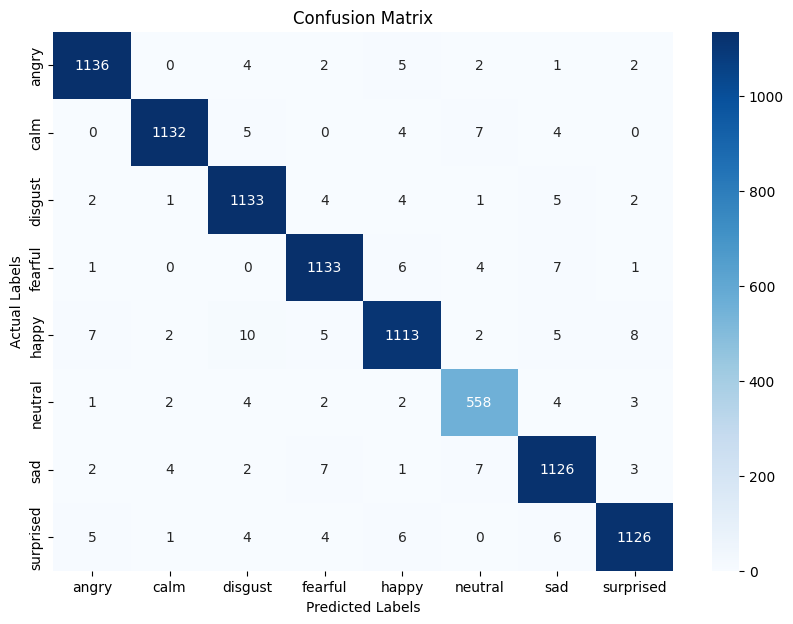

              precision    recall  f1-score   support

       angry       0.98      0.99      0.99      1152
        calm       0.99      0.98      0.99      1152
     disgust       0.98      0.98      0.98      1152
     fearful       0.98      0.98      0.98      1152
       happy       0.98      0.97      0.97      1152
     neutral       0.96      0.97      0.96       576
         sad       0.97      0.98      0.97      1152
   surprised       0.98      0.98      0.98      1152

    accuracy                           0.98      8640
   macro avg       0.98      0.98      0.98      8640
weighted avg       0.98      0.98      0.98      8640

Weights: [0.0, 0.7, 0.8]
Weighted Ensemble Accuracy: 0.9788194444444445
Best Rank 0
Best Ensemble Method: Weighted
Best Ensemble Model: ['LSTM', 'GRU', 'BiLSTM']
270/270 [==============================] - 12s 46ms/step


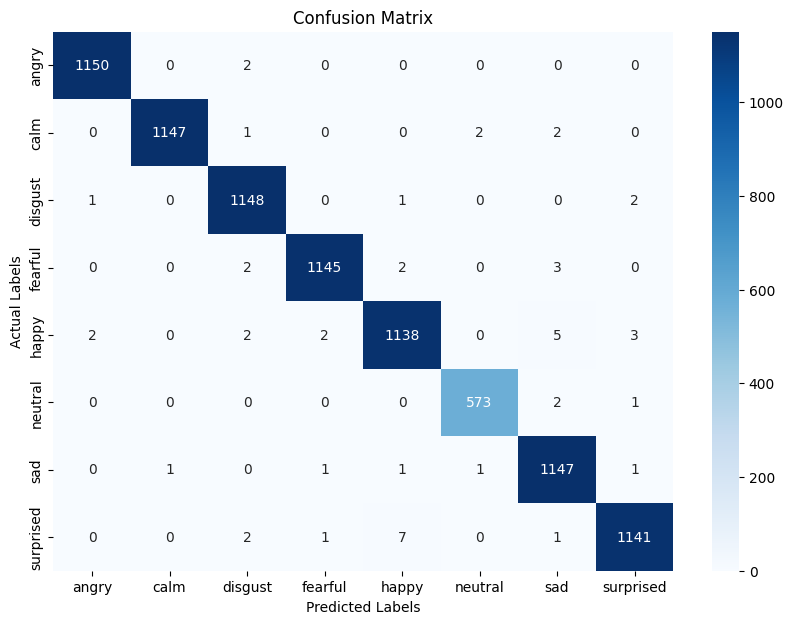

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00      1152
        calm       1.00      1.00      1.00      1152
     disgust       0.99      1.00      0.99      1152
     fearful       1.00      0.99      1.00      1152
       happy       0.99      0.99      0.99      1152
     neutral       0.99      0.99      0.99       576
         sad       0.99      1.00      0.99      1152
   surprised       0.99      0.99      0.99      1152

    accuracy                           0.99      8640
   macro avg       0.99      0.99      0.99      8640
weighted avg       0.99      0.99      0.99      8640

Weights: [0.1, 0.3, 0.2]
Weighted Ensemble Accuracy: 0.9940972222222222
Best Rank 1
Best Ensemble Method: Weighted
Best Ensemble Model: ['BiGRU', 'EfficientNetB1', 'ResNet50V2']
270/270 [==============================] - 7s 26ms/step


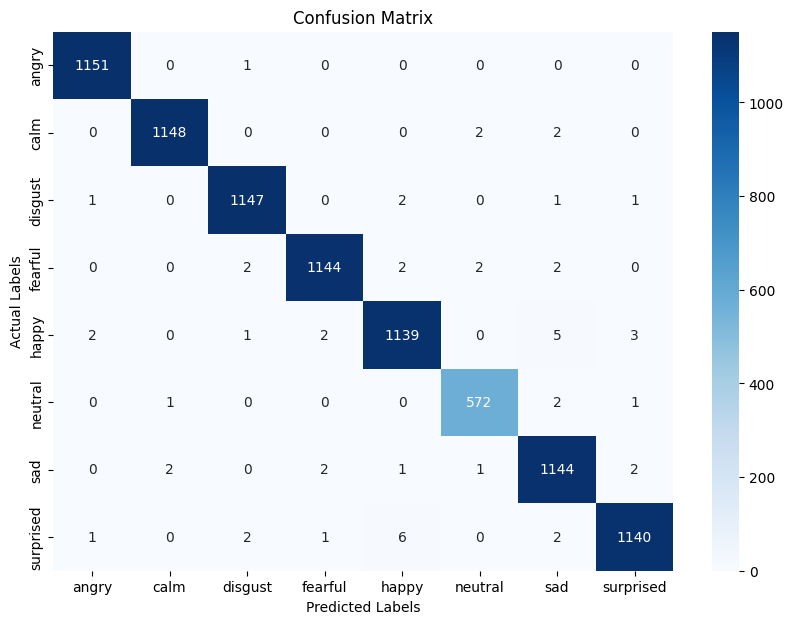

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00      1152
        calm       1.00      1.00      1.00      1152
     disgust       0.99      1.00      1.00      1152
     fearful       1.00      0.99      0.99      1152
       happy       0.99      0.99      0.99      1152
     neutral       0.99      0.99      0.99       576
         sad       0.99      0.99      0.99      1152
   surprised       0.99      0.99      0.99      1152

    accuracy                           0.99      8640
   macro avg       0.99      0.99      0.99      8640
weighted avg       0.99      0.99      0.99      8640

Weights: [0.4, 1.0, 0.7]
Weighted Ensemble Accuracy: 0.9936342592592593
Best Rank 2
Best Ensemble Method: Weighted
Best Ensemble Model: ['LSTM', 'EfficientNetB1', 'ResNet50V2']
270/270 [==============================] - 8s 31ms/step


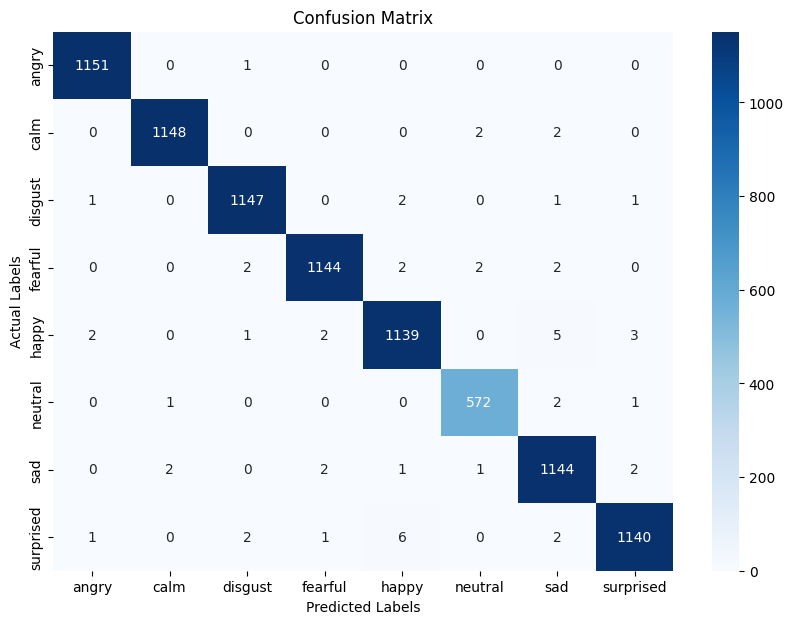

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00      1152
        calm       1.00      1.00      1.00      1152
     disgust       0.99      1.00      1.00      1152
     fearful       1.00      0.99      0.99      1152
       happy       0.99      0.99      0.99      1152
     neutral       0.99      0.99      0.99       576
         sad       0.99      0.99      0.99      1152
   surprised       0.99      0.99      0.99      1152

    accuracy                           0.99      8640
   macro avg       0.99      0.99      0.99      8640
weighted avg       0.99      0.99      0.99      8640

Weights: [0.4, 1.0, 0.7]
Weighted Ensemble Accuracy: 0.9936342592592593
Best Rank 3
Best Ensemble Method: Weighted
Best Ensemble Model: ['GRU', 'EfficientNetB1', 'ResNet50V2']
270/270 [==============================] - 7s 24ms/step


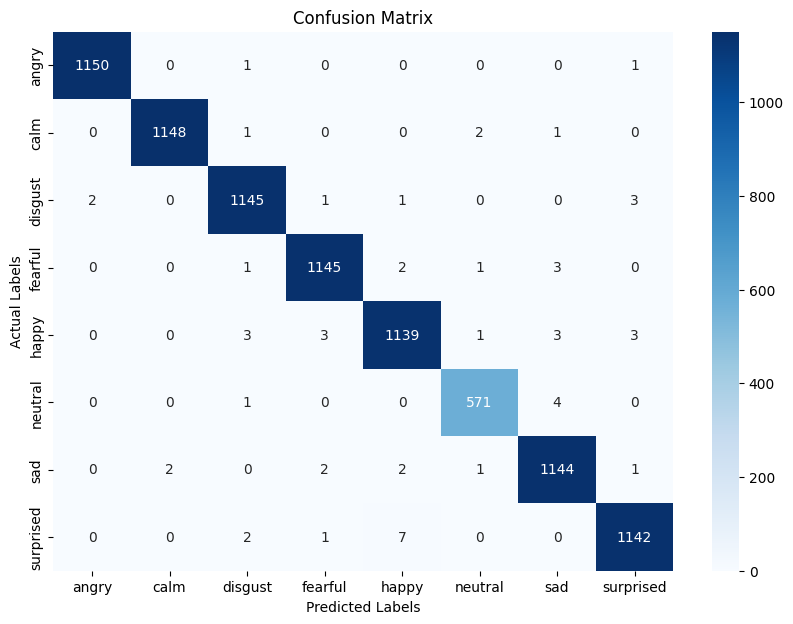

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00      1152
        calm       1.00      1.00      1.00      1152
     disgust       0.99      0.99      0.99      1152
     fearful       0.99      0.99      0.99      1152
       happy       0.99      0.99      0.99      1152
     neutral       0.99      0.99      0.99       576
         sad       0.99      0.99      0.99      1152
   surprised       0.99      0.99      0.99      1152

    accuracy                           0.99      8640
   macro avg       0.99      0.99      0.99      8640
weighted avg       0.99      0.99      0.99      8640

Weights: [0.8, 0.2, 0.9]
Weighted Ensemble Accuracy: 0.9935185185185185
Best Rank 4
Best Ensemble Method: Weighted
Best Ensemble Model: ['BiGRU', 'CNN', 'EfficientNetB1']
270/270 [==============================] - 7s 27ms/step


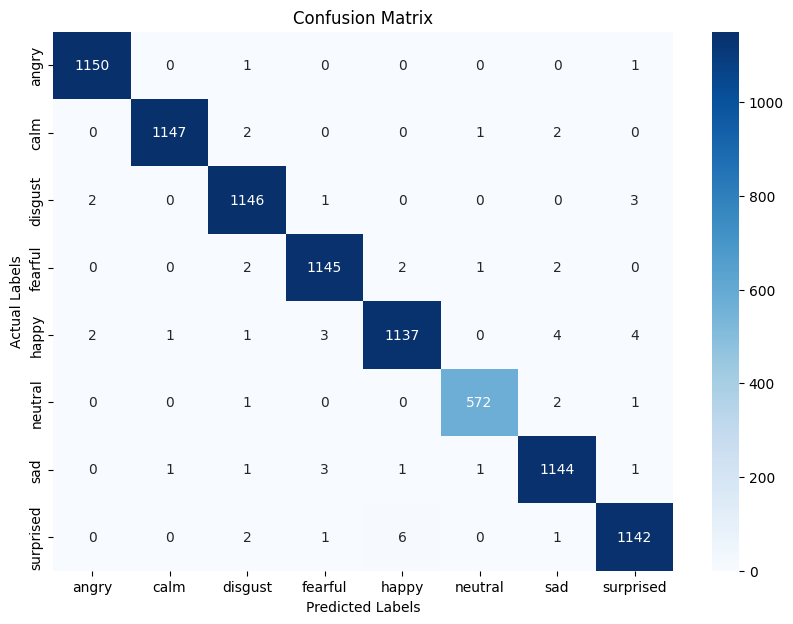

              precision    recall  f1-score   support

       angry       1.00      1.00      1.00      1152
        calm       1.00      1.00      1.00      1152
     disgust       0.99      0.99      0.99      1152
     fearful       0.99      0.99      0.99      1152
       happy       0.99      0.99      0.99      1152
     neutral       0.99      0.99      0.99       576
         sad       0.99      0.99      0.99      1152
   surprised       0.99      0.99      0.99      1152

    accuracy                           0.99      8640
   macro avg       0.99      0.99      0.99      8640
weighted avg       0.99      0.99      0.99      8640

Weights: [0.2, 0.8, 0.5]
Weighted Ensemble Accuracy: 0.9934027777777777
Best Rank 5
Best Ensemble Method: Weighted
Best Ensemble Model: ['CNN', 'EfficientNetB1', 'ResNet50V2']


In [41]:
for index in range(6):
    create_ensemble_model_report(index)